In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import torchvision.transforms.functional as tvf
import torchvision.utils as tvu
from torch import Tensor
import torchvision.transforms as tvt
import os
from tqdm import tqdm
import random
from torchvision import datasets
from positional_embeddings import PositionalEmbedding

## Utils

In [2]:
# 将一个PIL图像Resize后并转换为Tensor
def resize2tensor(image: Image, size: int) -> Tensor:
    transform = tvt.Compose([
        tvt.Resize(size, interpolation=tvf.InterpolationMode.BICUBIC),
        tvt.ToTensor()
    ])
    return transform(image)


def show_images_tensor(images_per_row: int, images_tensor: Tensor, size=16):
    """
    展示图片
    :param images_per_row: 每行展示的图片数量
    :param images_tensor: B*C*W*H
    :return:
    """

    # Create a grid of images using make_grid
    grid = tvu.make_grid(images_tensor, nrow=images_per_row, padding=2, normalize=False)

    # plot绘画需要W*H*C的图片，即通道在最后一维
    grid_np = grid.numpy().transpose((1, 2, 0))

    # Display the grid of images using matplotlib
    plt.figure(figsize=(size, size))
    plt.imshow(grid_np)
    plt.axis("off")
    plt.show()

## Dataset
要将图像转为值在[-1,1]之间的Tensor

In [3]:
train_dataset = datasets.MNIST(root='H:/dataset/MNIST',train=True,transform=tvt.ToTensor(),download=True)

In [4]:
ls = []
for batch in train_dataset:
    ls.append(batch[0]) # batch[0]是图像，batch[1]是标签
    
train_dataset = torch.stack(ls)
print(train_dataset.shape)

torch.Size([60000, 1, 28, 28])


In [5]:
batch_size=128

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

torch.Size([128, 1, 28, 28])


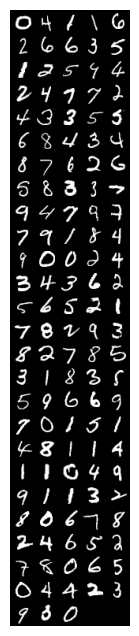

In [7]:
for batch in train_dataloader:
    print(batch.shape)
    show_images_tensor(5, batch, 8)
    break

### Set parameters and load data

总步数n_steps=1000，$\beta\in[10^{-4},0.02]$且为线性间隔取值

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

T = 500
# 注意下标从0开始
first_element = torch.Tensor([0]).to(device)
beta = torch.linspace(0.0001, 0.02, T).to(device)
# 在首位添加元素0，这样time step就和下标一一对应
beta = torch.cat((first_element, beta))
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sigma = torch.sqrt(beta)

In [9]:
print('beta[0:10]:', beta[0:11])
print('alpha[0:10]:', alpha[0:11])
print('alpha_bar[0:10]', alpha_bar[0:11])
print('sigma[0:10]', sigma[0:11])

beta[0:10]: tensor([0.0000e+00, 1.0000e-04, 1.3988e-04, 1.7976e-04, 2.1964e-04, 2.5952e-04,
        2.9940e-04, 3.3928e-04, 3.7916e-04, 4.1904e-04, 4.5892e-04],
       device='cuda:0')
alpha[0:10]: tensor([1.0000, 0.9999, 0.9999, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9996,
        0.9996, 0.9995], device='cuda:0')
alpha_bar[0:10] tensor([1.0000, 0.9999, 0.9998, 0.9996, 0.9994, 0.9991, 0.9988, 0.9985, 0.9981,
        0.9977, 0.9972], device='cuda:0')
sigma[0:10] tensor([0.0000, 0.0100, 0.0118, 0.0134, 0.0148, 0.0161, 0.0173, 0.0184, 0.0195,
        0.0205, 0.0214], device='cuda:0')


### Get $x_t$
$$\boldsymbol{x_t}=\sqrt{\bar{\alpha}_t}\boldsymbol{x_0}+\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}$$
$$\boldsymbol{\epsilon}\sim N(0,I)$$
对于`get_xt_given_x0_and_t`，每次使用的$\boldsymbol{\epsilon}$是一样的，应该从外部传入

In [10]:
def get_xt_given_x0_and_t(x0, t, eps):
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_sqrt_alpha_bar_t = torch.sqrt(1-alpha_bar[t]).view(-1, 1, 1, 1)
    #print('sqrt_alpha_bar_t',sqrt_alpha_bar_t.shape)
    #print('sqrt_one_minus_sqrt_alpha_bar_t',sqrt_one_minus_sqrt_alpha_bar_t.shape)
    #print('x0',x0.shape)
    #print('t',t.shape)
    mean = sqrt_alpha_bar_t * x0
    std = sqrt_one_minus_sqrt_alpha_bar_t
    xt = mean + std * eps
    return xt

In [11]:
def show_diffusion():
    diffusion = []
    step = 50 #扩散步长
    idx = random.randint(0, batch_size)
    for batch in train_dataloader:
        x0 = batch[idx].to(device)
        # 扩散过程
        for t in range(1, T+1, step):
            eps = torch.randn_like(x0).to(device)
            xt = get_xt_given_x0_and_t(x0, t, eps)
            diffusion.append(xt)
        # 还原为向量
        diffusion = torch.stack(diffusion).reshape(-1, 1, 28, 28)
        break
        
    print(diffusion.shape)
    show_images_tensor(5, diffusion.cpu(), 4)

torch.Size([10, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


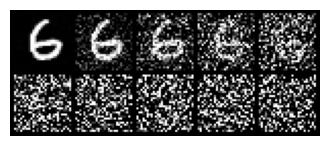

In [12]:
show_diffusion()

### Sampling with trained model
$$\boldsymbol{x}_{t-1}=\frac{1}{\sqrt{\alpha}}(\boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}*\boldsymbol{\epsilon}_\theta(\boldsymbol{x}_t, t))+\sigma_t*\boldsymbol{z}$$
$$\boldsymbol{z}\sim N(0,I)$$

In [13]:
def sampling(xt, T, model, start, end, step):
    """
    xt: (batch_size, 1, 28, 28)
    """
    sampling_results = []
    # 计算x_{T-1},...,x0
    for i in range(T, 0, -1):
        z = torch.randn(*xt.shape).to(device)
        #print('z', z.shape)
        t = (torch.zeros((1,))+i).long().to(device)
        #print('t', t.shape)
        eps_theta = model(xt, t).reshape(-1, 1, 28, 28)
        #print('eps_theta', eps_theta.shape)
        assert not torch.any(torch.isnan(eps_theta)), 'in function `sampling`, eps_theta is nan!'

        coeff = 1. / torch.sqrt(alpha[i])
        coeff_eps_theta = (1-alpha[i]) / torch.sqrt(1 - alpha_bar[i])
        
        if i == 1:
            z=0
        xt = coeff * (xt - coeff_eps_theta * eps_theta) + sigma[i] * z
        #print('xt', xt.shape)
        # 存放结果，在[start, end]中每step取一个样本
        #if i >= start and i <= end and (i-1) % step == 0 or i == end:
            #sampling_results.append(xt)

    #sampling_results = torch.stack(sampling_results) # (?, 1, 28, 28)

    return xt#sampling_results

## Model

In [14]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


In [15]:
class MLP(nn.Module):
    def __init__(self, time_emb: str = "sinusoidal", hidden_size=256, emb_size: int = 28*28):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.layers = nn.Sequential(
            nn.Conv2d(1, 128, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, 1, 2),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1),
        )
        self.conv_layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, 1, 1)
        )
        
    def forward(self, x, t):
        x = self.layers(x) # (batch_size, 32, 28, 28)
        t_emb = self.time_mlp(t).view(-1, 1, 28, 28) # (batch_size, emb_size)
        #print('t_emb', t_emb.shape)
        v = x + t_emb # (batch_size, 32, 28, 28)
        v = self.conv_layers(v)# (batch_size, 1, 28, 28)
        return v # (batch_size, 1, 28, 28)

In [16]:
class AverageLogger(object):
    def __init__(self):
        super().__init__()
        self.avg = 0
        self.cnt = 0
        self.sum = 0

    def update(self, x, n=1):
        self.sum += x
        self.cnt += n
        self.avg = self.sum / self.cnt

    def clear(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0

In [17]:
model = MLP().to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

### Train the model
$$\nabla_{\theta}\Vert \boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}(x_t, t)\Vert^2$$

In [18]:
epoch_num = 200

model.train() # 开启训练模式！
training_samples_size = len(train_dataloader) * batch_size # len(training_dataloader)是training_dataloader的批次数目


for i in range(epoch_num):
    with tqdm(total=training_samples_size, ncols=100) as p_bar:
        # 设置进度条描述
        p_bar.set_description(f'Epoch: {i + 1}')
        for input_images in train_dataloader:
            x0 = batch.to(device)
            #print(x0.shape)

            eps = torch.randn(x0.shape).to(device)

            t = torch.randint(1, T, (batch_size,)).long().to(device)

            xt = get_xt_given_x0_and_t(x0, t, eps)

            eps_theta = model(xt, t).reshape(-1, 1, 28, 28)

            # assert not torch.isnan(eps_theta).any(), "NaN values found in eps_theta"

            loss = criterion(eps_theta, eps)
            loss.backward()
            # 记录损失
            p_bar.set_postfix({'loss': loss.item()})
            
            # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # 打印梯度
            #for name, param in model.named_parameters():
                #if param.grad is not None:
                    #print(name, torch.max(param.grad))

            # nn.utils.clip_grad_norm_(model.parameters(), 2, norm_type=2) # 梯度裁剪

            optimizer.step()
            optimizer.zero_grad()
            
            # 更新进度条&显示损失及指标
            p_bar.update(x0.shape[0])

Epoch: 200: 100%|██████████████████████████████| 59904/59904 [00:27<00:00, 2168.14it/s, loss=0.0268]


In [19]:
print("Saving model...")
torch.save(model.state_dict(), "model.pth")

Saving model...


## Sampling

In [52]:
model.eval() # 开启评估模式！
with torch.no_grad():
    noise = torch.randn(16, 1, 28, 28).to(device)
    sampling_results = sampling(noise, T, model, 1, T, 50)

In [53]:
sampling_results = sampling_results.detach().cpu()

In [54]:
sampling_results.shape

torch.Size([16, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


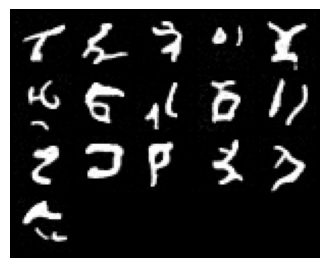

In [55]:
show_images_tensor(5, sampling_results.reshape(-1, 1, 28, 28).cpu(), 4)